## Netdata Anomaly Detection Deepdive

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/andrewm4894/netdata/blob/add-ml-notebooks/ml/notebooks/netdata%20anomaly%20detection%20deepdive.ipynb)

This notebook will walk through a simplified python based implementation of the C & C++ code in [`netdata/netdata/ml/`](https://github.com/netdata/netdata/tree/master/ml) used to power the [anomaly detection capabilities](https://github.com/netdata/netdata/blob/master/ml/README.md) of the Netdata agent.

The main goal here is to help interested users learn more about how the machine learning works under the hood.

🚧 **Note**: This functionality is still under active development and considered experimental. Changes might cause the feature to break. We dogfood it internally and among early adopters within the Netdata community to build the feature. If you would like to get involved and help us with some feedback, email us at analytics-ml-team@netdata.cloud or come join us in the [🤖-ml-powered-monitoring](https://discord.gg/4eRSEUpJnc) channel of the Netdata discord.

In this notebook we will:

1. Pull some recent data from one of our demo agents.
2. Be evil and mess up the tail end of the data to make it obviously "anomalous".
3. Implement an unsupervised clustering based approach to anomaly detection.
4. Plot and explore all this visually.
5. Dig a little deeper on what's going on under the hood.

### Imports & Helper Functions

Uncomment and run the next cell to install [netdata-pandas](https://github.com/netdata/netdata-pandas) which we will use to easily pull data from the [Netdata agent REST API](https://learn.netdata.cloud/docs/agent/web/api) into a nice clean [Pandas](https://pandas.pydata.org/) [DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) where it will be easier to work with. 

Once you have [netdata-pandas] installed you can comment it back out and rerun the cell to clear the output.

In [1]:
#!pip install netdata-pandas

In [2]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from netdata_pandas.data import get_data

# helper functions


def preprocess_df(df, lags_n, diffs_n, smooth_n):
    """Given a pandas dataframe preprocess it to take differences, add smoothing, lags and abs values. 
    """
    if diffs_n >= 1:
        # take differences
        df = df.diff(diffs_n).dropna()
    if smooth_n >= 2:
        # apply a rolling average to smooth out the data a bit
        df = df.rolling(smooth_n).mean().dropna()
    if lags_n >= 1:
        # for each dimension add a new columns for each of lags_n lags of the differenced and smoothed values for that dimension
        df_columns_new = [f'{col}_lag{n}' for n in range(lags_n+1) for col in df.columns]
        df = pd.concat([df.shift(n) for n in range(lags_n + 1)], axis=1).dropna()
        df.columns = df_columns_new
    # sort columns to have lagged values next to each other for clarity when looking at the feature vectors
    df = df.reindex(sorted(df.columns), axis=1)
    
    # take absolute values as lasat step
    df = abs(df)
    
    return df


def add_shading_to_plot(ax, a, b, t, c='y', alpha=0.2):
    """Helper function to add shading to plot and add legend item.
    """
    plt.axvspan(a, b, color=c, alpha=alpha, lw=0)
    handles, labels = ax.get_legend_handles_labels()
    patch = mpatches.Patch(color=c, label=t, alpha=alpha)
    handles.append(patch) 
    plt.legend(handles=handles)



### Inputs & Parameters

A full list of all the anomaly detection configuration parameters, and descriptions of each, can be found in the [configuration](https://github.com/netdata/netdata/blob/master/ml/README.md#configuration) section of the [ml readme](https://github.com/netdata/netdata/blob/master/ml/README.md).

Below we will focus on some basic params to decide what data to pull and the main ml params of importance in understanding how it all works.

In [3]:
# data params
hosts = ['london.my-netdata.io']
charts = ['system.cpu']
# if want to just focus on a subset of dims
dims = ['system.cpu|user'] 
last_n_hours = 2
before = int(datetime.utcnow().timestamp())
after = int((datetime.utcnow() - timedelta(hours=last_n_hours)).timestamp())

# ml params
train_every = 3600
num_samples_to_train = 3600
num_samples_to_diff = 1
num_samples_to_smooth = 3
num_samples_to_lag = 5
dimension_anomaly_score_threshold = 0.99
n_clusters_per_dimension = 2
max_iterations = 1000

(7200, 1)
1646252786 1646259985


,system.cpu|user
time_idx,
1646252786,0.500000
1646252787,1.500000
1646252788,0.502513
1646252789,1.253133
1646252790,0.751880


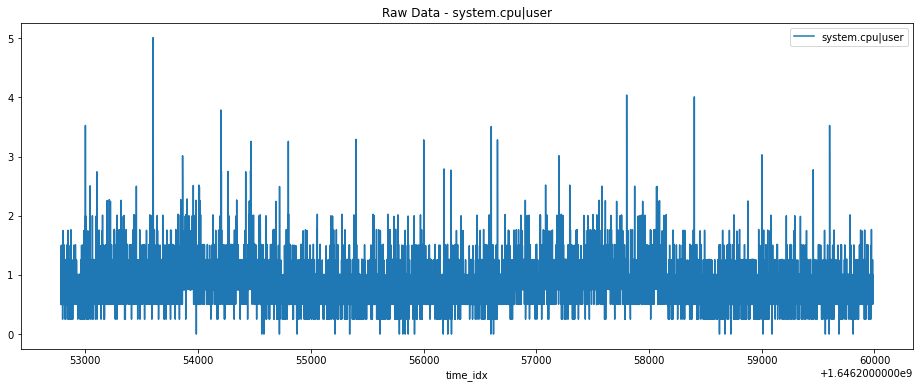

In [4]:
# get raw data
df = get_data(hosts=hosts, charts=charts, after=after, before=before)
if len(dims):
    df = df[[dim for dim in dims]]
print(df.shape)

# set some variables based on our data
df_timestamp_min = df.index.min()
df_timestamp_max = df.index.max()
print(df_timestamp_min, df_timestamp_max)

display(df.head())

# lets just plot each dimension
for col in df.columns:
    df.plot(title=f'Raw Data - {col}', figsize=(16,6))

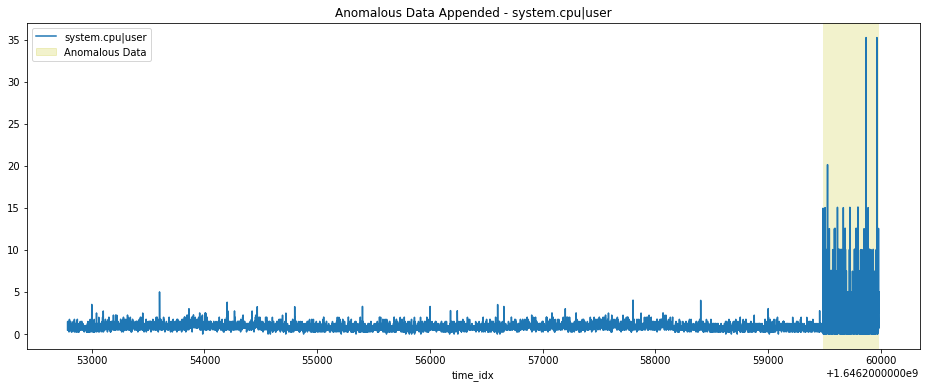

In [5]:
# size of anomalous data
n_tail_anomalous = 500

# randomly scramble data and multiply randomly by some numbers to make it anomalous looking
anomalous_shape = (n_tail_anomalous,len(df.columns))
data_anomalous = np.random.choice(df.tail(n_tail_anomalous).values.reshape(-1,),anomalous_shape) * np.random.choice([0,1,5,10],anomalous_shape)

# create anomalous dataframe
df_anomalous = pd.DataFrame(data = data_anomalous, columns = df.columns)
df_anomalous.index = df.tail(n_tail_anomalous).index

# overwrite last n_tail observations with anomalous data
df.update(df_anomalous)

# lets just plot each dimension now that we have added some anomalous data
for col in df.columns:
    ax = df.plot(title=f'Anomalous Data Appended - {col}', figsize=(16,6))
    add_shading_to_plot(ax, df_timestamp_max - n_tail_anomalous, df_timestamp_max, 'Anomalous Data')

In [6]:
# initialize an empty kmeans model for each dimension
models = {
    dim: {
        'model' : KMeans(
            n_clusters=n_clusters_per_dimension, 
            max_iter=max_iterations
        ),
        'fitted': False
    }
    for dim in df.columns
}

# initialize dictionary for anomaly scores
anomaly_scores = {
    dim: {
        't' : [],
        'anomaly_score': []
    }
    for dim in df.columns
}

# initialize dictionary for anomaly bits
anomaly_bits = {
    dim: {
        't' : [],
        'anomaly_bit': []
    }
    for dim in df.columns
}

In [7]:
# loop over each row of data in df
for t, row in df.iterrows():

    # get n based on timestep
    n = t - df_timestamp_min

    # for each dim, if we have a fitted model then make predictions
    for dim in df.columns:

        # if we have a fitted model, get anomaly score
        if models[dim]['fitted']:

            # get recent data
            buffer_size = num_samples_to_diff + num_samples_to_smooth + num_samples_to_lag * 2
            df_dim_recent = df[[dim]].loc[(t-buffer_size):t]

            # preprocess/featurize recent data
            df_dim_recent_preprocessed = preprocess_df(
                df_dim_recent,
                num_samples_to_lag,
                num_samples_to_diff,
                num_samples_to_smooth
            )

            # take most recent feature vector
            X = df_dim_recent_preprocessed.tail(1).values

            # get anomaly score
            anomaly_score = np.sum(cdist(X, models[dim]['model'].cluster_centers_, metric='euclidean'), axis=1)[0]

            # normalize anomaly score
            anomaly_score = (anomaly_score - models[dim]['train_anomaly_score_min']) / (models[dim]['train_anomaly_score_max'] - models[dim]['train_anomaly_score_min'] )

            # get anomaly bit
            anomaly_bit = 100 if anomaly_score >= dimension_anomaly_score_threshold else 0
            
            # save anomaly score
            anomaly_scores[dim]['t'].append(t)
            anomaly_scores[dim]['anomaly_score'].append(anomaly_score)

            # save anomaly bit
            anomaly_bits[dim]['t'].append(t)
            anomaly_bits[dim]['anomaly_bit'].append(anomaly_bit)
    
    # check if need to train or retrain
    if (n >= num_samples_to_train) & (n % train_every == 0):

        train_before = t - num_samples_to_train
        train_after = t
        print(f'train at t={t}, (n={n}, train_after={train_after}, train_before={train_before})')

        # loop over each dimension/model
        for dim in df.columns:
            
            # get training data
            df_dim_train = df[[dim]].loc[(t-num_samples_to_train):t]
            
            # preprocess/featurize training data
            df_dim_train_preprocessed = preprocess_df(
                df_dim_train,
                num_samples_to_lag,
                num_samples_to_diff,
                num_samples_to_smooth
            )

            # fit model
            models[dim]['model'].fit(df_dim_train_preprocessed.values) 
            models[dim]['fitted'] = True

            # get training scores
            train_anomaly_scores = np.sum(cdist(df_dim_train_preprocessed.values, models[dim]['model'].cluster_centers_, metric='euclidean'), axis=1)
            # save min and max anomaly score during training, used to normalize all scores to be 0,1 scale
            models[dim]['train_anomaly_score_min'] = min(train_anomaly_scores)
            models[dim]['train_anomaly_score_max'] = max(train_anomaly_scores)


train at t=1646256386, (n=3600, train_after=1646256386, train_before=1646252786)


In [8]:
# create dataframe of anomaly scores
df_anomaly_scores = pd.DataFrame()
for dim in anomaly_scores:
    df_anomaly_scores_dim = pd.DataFrame(data=zip(anomaly_scores[dim]['t'],anomaly_scores[dim]['anomaly_score']),columns=['time_idx',f'{dim}__anomaly_score']).set_index('time_idx')
    df_anomaly_scores = df_anomaly_scores.join(df_anomaly_scores_dim, how='outer')

# create dataframe of anomaly bits
df_anomaly_bits = pd.DataFrame()
for dim in anomaly_bits:
    df_anomaly_bits_dim = pd.DataFrame(data=zip(anomaly_bits[dim]['t'],anomaly_bits[dim]['anomaly_bit']),columns=['time_idx',f'{dim}__anomaly_bit']).set_index('time_idx')
    df_anomaly_bits = df_anomaly_bits.join(df_anomaly_bits_dim, how='outer')

# join anomaly scores to raw df
df_final = df.join(df_anomaly_scores, how='outer')

# join anomaly bits to raw df
df_final = df_final.join(df_anomaly_bits, how='outer')

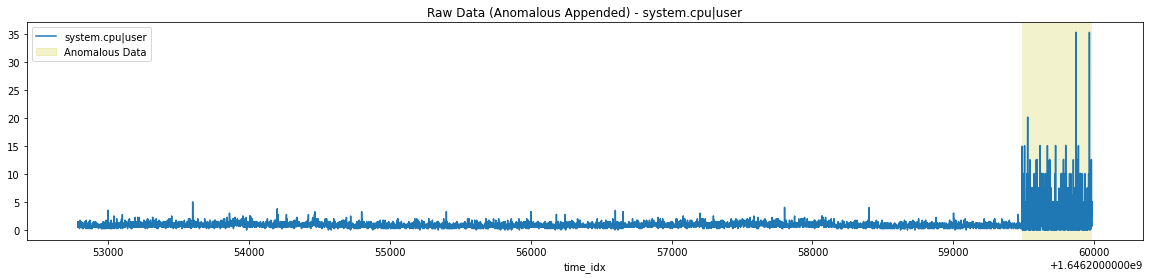

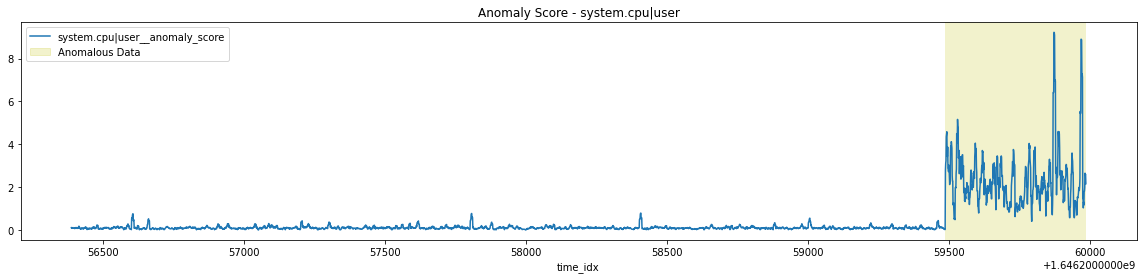

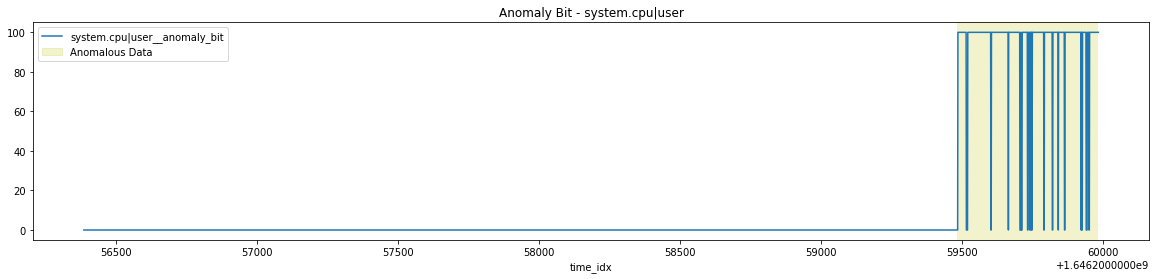

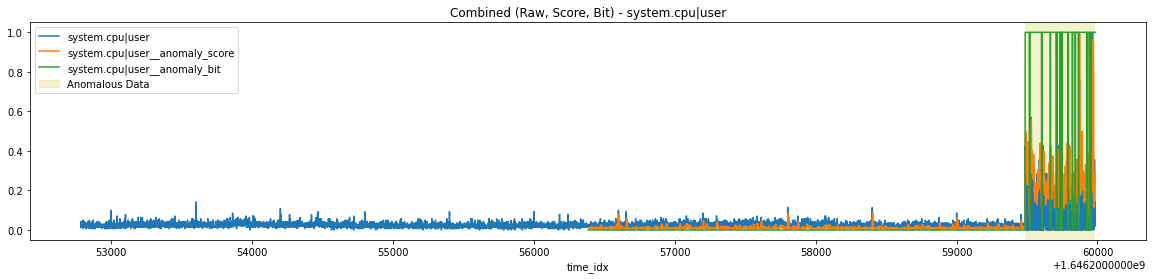

In [9]:
figsize = (20,4)

for dim in models:

    df_final_dim = df_final[[dim,f'{dim}__anomaly_score',f'{dim}__anomaly_bit']]
    ax = df_final_dim[[dim]].plot(title=f'Raw Data (Anomalous Appended) - {dim}', figsize=figsize)
    add_shading_to_plot(ax, df_timestamp_max - n_tail_anomalous, df_timestamp_max, 'Anomalous Data')
    
    ax = df_final_dim[[f'{dim}__anomaly_score']].plot(title=f'Anomaly Score - {dim}', figsize=figsize)
    add_shading_to_plot(ax, df_timestamp_max - n_tail_anomalous, df_timestamp_max, 'Anomalous Data')
    
    ax = df_final_dim[[f'{dim}__anomaly_bit']].plot(title=f'Anomaly Bit - {dim}', figsize=figsize)
    add_shading_to_plot(ax, df_timestamp_max - n_tail_anomalous, df_timestamp_max, 'Anomalous Data')

    df_final_dim_normalized = (df_final_dim-df_final_dim.min())/(df_final_dim.max()-df_final_dim.min())
    ax = df_final_dim_normalized.plot(title=f'Combined (Raw, Score, Bit) - {dim}', figsize=figsize)
    add_shading_to_plot(ax, df_timestamp_max - n_tail_anomalous, df_timestamp_max, 'Anomalous Data')

In [10]:
n_tail_anomalous_anomaly_rate = df_final_dim[[f'{dim}__anomaly_bit']].tail(n_tail_anomalous).mean()[0]

print(f'n_tail_anomalous_anomaly_rate = {n_tail_anomalous_anomaly_rate}%')

n_tail_anomalous_anomaly_rate = 92.4%


In [11]:
# preprocess/featurize all data
df_preprocessed = preprocess_df(
    df,
    num_samples_to_lag,
    num_samples_to_diff,
    num_samples_to_smooth
)
print(df_preprocessed.shape)
df_preprocessed.head()

(7192, 6)


,system.cpu|user_lag0,system.cpu|user_lag1,system.cpu|user_lag2,system.cpu|user_lag3,system.cpu|user_lag4,system.cpu|user_lag5
time_idx,,,,,,
1646252794,0.168134,0.085226,0.082703,0.083122,0.249373,0.251044
1646252795,0.167504,0.168134,0.085226,0.082703,0.083122,0.249373
1646252796,0.084596,0.167504,0.168134,0.085226,0.082703,0.083122
1646252797,0.083752,0.084596,0.167504,0.168134,0.085226,0.082703
1646252798,0.000422,0.083752,0.084596,0.167504,0.168134,0.085226


In [12]:
df_preprocessed.sample(5)

,system.cpu|user_lag0,system.cpu|user_lag1,system.cpu|user_lag2,system.cpu|user_lag3,system.cpu|user_lag4,system.cpu|user_lag5
time_idx,,,,,,
1646253558,0.165407,0.169619,7.996633e-02,0.083963,0.000633,8.607377e-02
1646256086,0.002544,0.167504,4.440892e-16,0.169203,0.001675,1.666646e-01
1646253016,0.170875,0.333748,8.502107e-02,0.168986,0.333536,1.295260e-16
1646253608,0.167084,0.002104,4.215115e-01,1.169591,0.084378,3.383923e-01
1646253200,0.086074,0.167084,8.375207e-02,0.079966,0.417711,1.675042e-01


In [13]:
model = 'system.cpu|user'
df_cluster_centers = pd.DataFrame(models[model]['model'].cluster_centers_, columns=df_preprocessed.columns)
df_cluster_centers.index = [f'centroid {i}' for i in df_cluster_centers.index.values]
df_cluster_centers

,system.cpu|user_lag0,system.cpu|user_lag1,system.cpu|user_lag2,system.cpu|user_lag3,system.cpu|user_lag4,system.cpu|user_lag5
centroid 0,0.098116,0.151273,0.149058,0.096559,0.147897,0.149986
centroid 1,0.287767,0.124229,0.130951,0.292654,0.134902,0.128568


<AxesSubplot:>

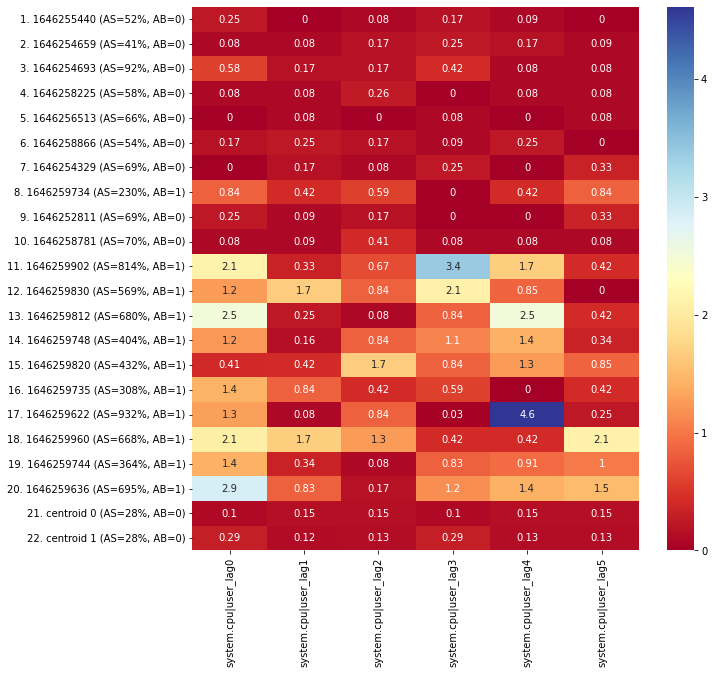

In [14]:
# prepare heatmap
df_heatmap = pd.concat([df_preprocessed.sample(10),df_preprocessed.tail(n_tail_anomalous).sample(10), df_cluster_centers])
df_heatmap = df_heatmap.round(2)

# get scores
heatmap_scores = np.sum(cdist(df_heatmap, models[dim]['model'].cluster_centers_, metric='euclidean'), axis=1)
heatmap_bits = [1 if score >= dimension_anomaly_score_threshold else 0 for score in heatmap_scores]

# add anomaly score to index
heatmap_index_inputs = list(zip(range(1, len(df_heatmap)+1), df_heatmap.index, heatmap_scores, heatmap_bits))
df_heatmap.index = [f'{x[0]}. {x[1]} (AS={round(x[2]*100)}%, AB={x[3]})' for x in heatmap_index_inputs]

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df_heatmap, annot=True, ax=ax, cmap='RdYlBu')

<AxesSubplot:>

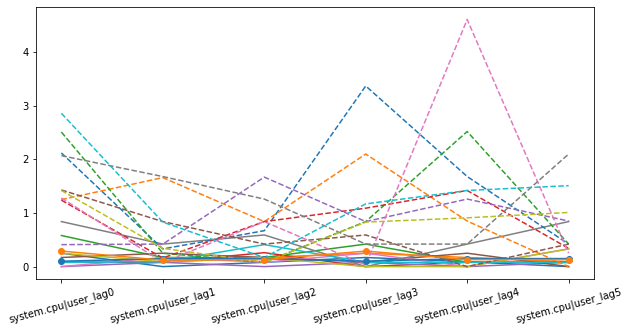

In [15]:
line_styles = ['-' for i in range(10)] + ['--' for i in range(10)] + ['o-' for i in range(2)]
df_heatmap.transpose().plot(legend=False, style=line_styles, figsize=(10,5), rot=15)

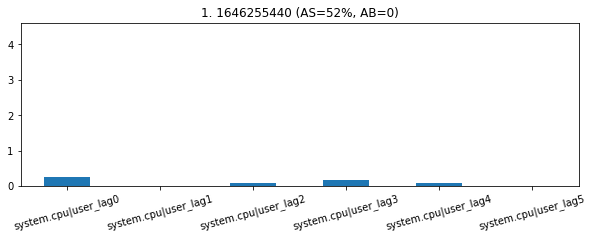

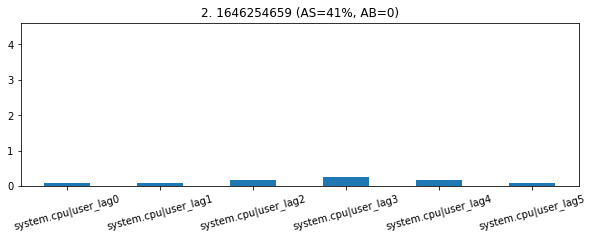

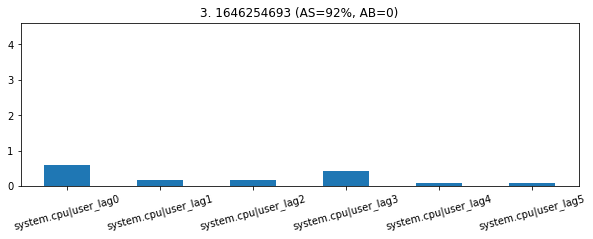

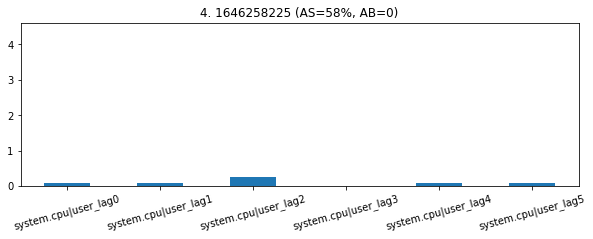

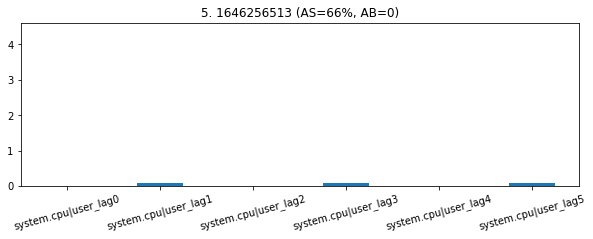

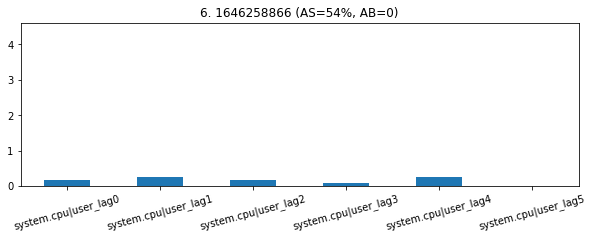

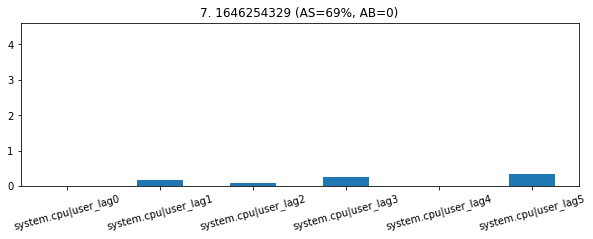

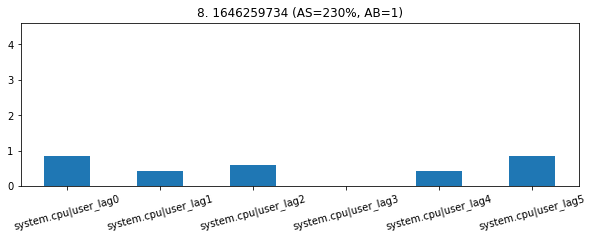

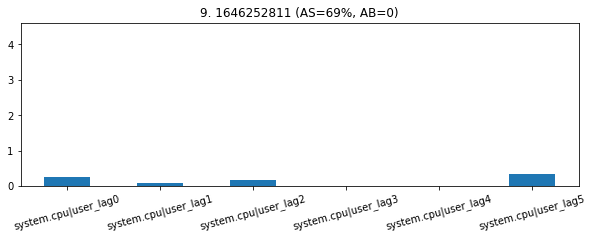

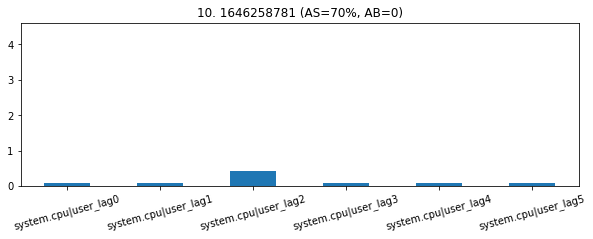

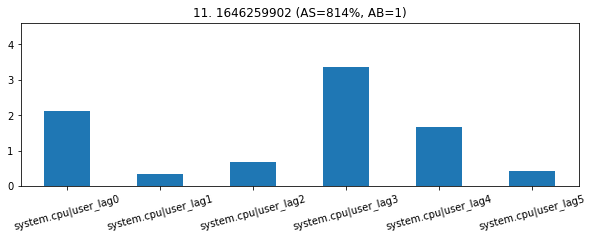

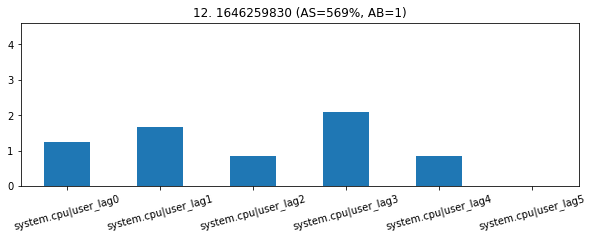

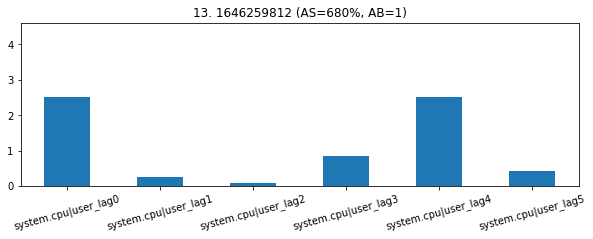

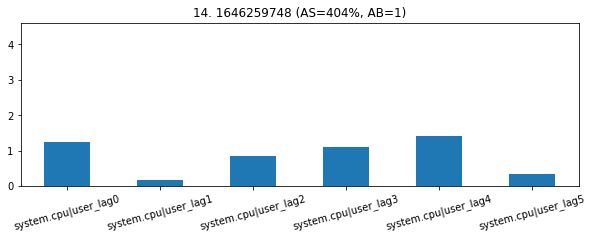

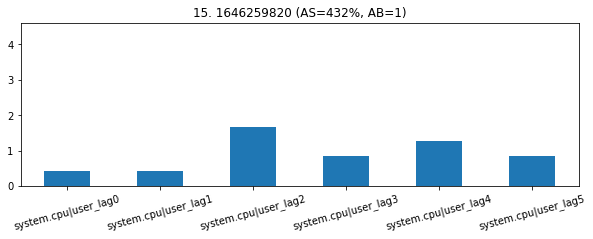

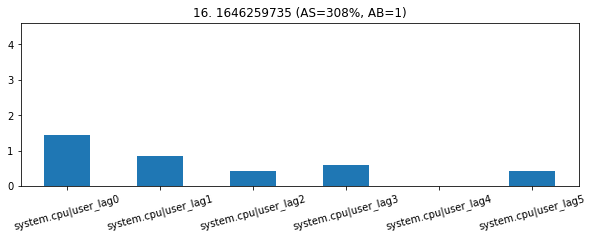

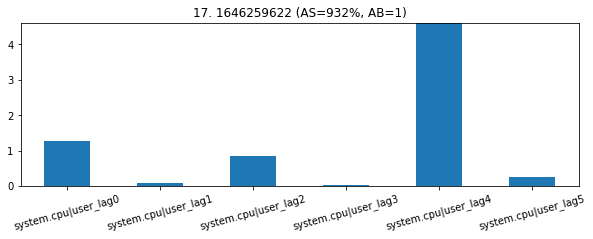

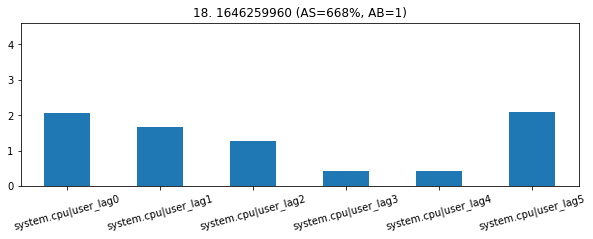

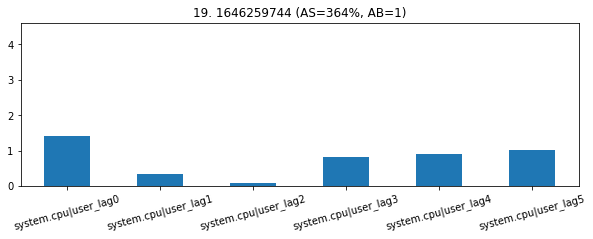

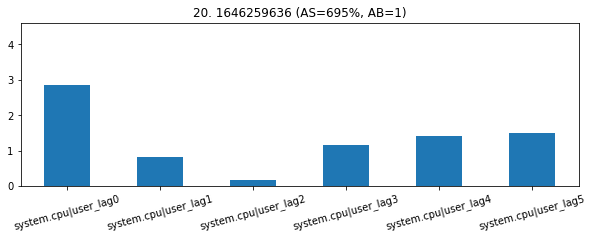

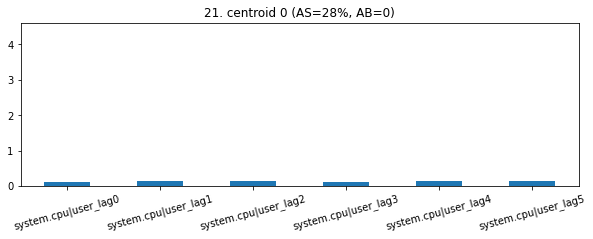

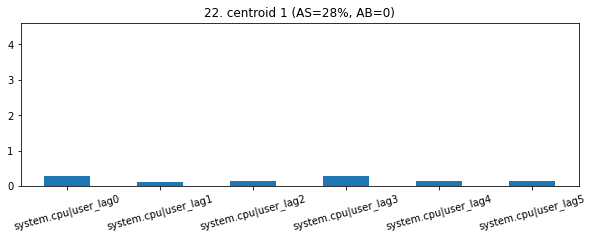

In [16]:
for n,r in enumerate(df_heatmap.iterrows()):
    i = r[0]
    row = r[1]
    ax = row.plot(kind='bar', figsize=(10,3),title=f'{i}', rot=15)
    ax.set_ylim(np.min(df_heatmap.values),np.max(df_heatmap.values))
    plt.show()